<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/ShawneeNF_TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Percent Tree Canopy Cover Notebook
## In this notebook we will explore how to build a simple random sample of point locations, extract remotely sensed data for those locations, and use that data to estimate % Tree Cover for the Shawnee National Forest.

### Project objective:
- Build a machine learning model from estimates of 2016 percent forest canopy cover, elevation data, and Landsat 8 imagery for that same time period
- Apply that model to elevation and Landsat 8 data acquired in 2021 to estimate percent forest canopy cover in 2021
- Compare our model estimates to [MLRC](https://www.mrlc.gov/data-services-page) % forest canopy cover estimates for the year 2021

#### Notebook Sections:
1. Setup
2. Create a Sample
3. Download data
4. Creating the Data Frame
5. Clean data
6. Preprocessing
7. Build a predictive model
8. Estimate Percent Tree Canopy Cover

#### Data sources
- [Landsat 8](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) - Extracted from Planetary Computer ([STAC](https://stacspec.org/en))
- [Tree Canopy Cover 2016](https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/NLCD_2016_TreeCanopyCover_CONUS/ImageServer) - Extracted from Landfire Image Service ([REST](https://developers.arcgis.com/rest/services-reference/enterprise/image-service/))
- [USGS Elevation](https://www.usgs.gov/3d-elevation-program) - Extracted from USGS 3DEP program ([py3dep](https://github.com/hyriver/py3dep))
- [National Forest Boundary](https://www.openstreetmap.org/#map=9/34.306/-112.242) - Extracted from Open Street Maps ([osmnx](https://osmnx.readthedocs.io/en/stable/))

Author John Hogland 10/1/2024

### Section 1: Setup
#### Installing software for Colab

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install py3dep==0.17.1

#### Importing packages

In [ ]:
#get packages
import osmnx as ox, planetary_computer, pystac_client, stackstac
import geopandas as gpd, pandas as pd, os, numpy as np, requests, urllib, py3dep

from raster_tools import Raster,zonal, general, Vector
from shapely import geometry

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

### Section 2: Create a sample
#### In this section we will extract the spatial boundary of the Shawnee National Forest using Open Street Maps (OSM) Web Service and create a simple random sample of locations within the boundary of the National forest.

#### Key learning points:
- Using OSM to get vector data (downloading)
- Generating a simple random sample of point location that will be used to create a data frame of response and predictor variables
- How to Visualize the the boundary and point locations

#### Coding Steps:
1. Use osmnx and OSM to get a GeoDataFrame (polygons) of the boundary of the Shawnee National Forest
2. Use the Shawnee National Forest boundary and Geopanda's sample_points function to create a simple random sample of point locations
3. Create a interactive map that displays our point locations

##### Step 1: Get the Shawnee National Forest boundary

In [ ]:
#use osmnx OpenStreetMaps to get the boundary of the NF (GeoDataFrame)
nf=ox.geocode_to_gdf('Shawnee National Forest, IL, USA')

#Look at the coordinate system of the GeoDataFrame
print('Original CRS =',nf.crs)

#project the GeoDataFrame to Albers equal area EPSG:5070
nfp=nf.to_crs(5070)

#Look at the GeoDataFrame
display(nfp)

#Plot the national forest
nfp.plot(figsize=(15,15))

#Why are we projecting to Albers equal Area?

#How many acres is the National Forest?
print('Number of acres =',(nfp.area * 0.000247105).values[0])

#How many polygons are in the National Forest?
print('Number of multipolygons =',nfp.shape[0])
print('Number of polygons =',nfp.explode().shape[0])



##### Step 3: Create the simple random sample

In [ ]:
#us random sample function to create 2,000 locations within the nfp
mpnts=nfp.sample_points(2000)

#Look at the GeoSeries
mpnts

#Why 2,000 locations? Why not 100 or 10,000?

#How many records do we have?
#print('Number of records =',mpnts.shape[0])

#How many observations do we have?
#print('Number of points (observations) =',mpnts.explode().shape[0])

#How can we convert our multipoint to points?
pnts=mpnts.explode().reset_index(drop=True) #reseting the index to clean things up

##### Step 4: Visualize the national forest boundary and point locations

In [ ]:
#Use geopandas explore function to create a interactive map
m=nfp.explore(color='blue') #create the map using the National Forest Boundary
m=pnts.explore(m=m,color='yellow') #add out points to the map
m #show the map

#Can we save our map to share with others?
#m.save('sample.html')

#How can we plot our map?
# p=nfp.plot(edgecolor='blue',facecolor='none',figsize=(15,15))
# p=pnts.plot(ax=p,color='yellow')
# p


### Section 3: Downloading Raster Data
#### In this section we will focus on download raster dataset from various sources.

#### Key learning points:
- Accessing data from different web services
- Deciding where to do your processing (client or server side)
- How and when to store the data locally
- How to visualizing the raster surfaces

#### Coding Steps:
1. Create functions to download data from STAC, REST, WCS
2. Use those functions to create Raster datasets
3. Visualize Your Raster datasets


##### Step 1: Creating download definitions

In [6]:
from owslib.wcs import WebCoverageService
#create definition to mosaic stac data
def mosaic_stac(xr):
    '''
    Creates a mosaic from multi-temporal xarray stack

    xr=Xarray object

    returns xarray mosaic
    '''
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(ply,url,name,bands,res=30,crs=5070,
                  out_prefix='ls8',**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    ply = (geoseries or geodataframe) of the study area
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource e.g., "sentinel-2-l2a"
    bands = (list(string)) of attributes ['red', 'blue', 'green', 'nir08', 'lwir11','swir16', 'swir22']
    qry =  (dictionary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return
    out_prefix = (string) prefix used to save the image

    returns a Raster object
    '''
    geo = ply.to_crs('4326').envelope.geometry[0]
    xmin,ymin,xmax,ymax=ply.total_bounds
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
        rs=Raster(xra.sel(band=bands,x=slice(xmin,xmax),y=slice(ymax,ymin)))
        outpath=out_prefix+'.tif'
        rs.save(outpath)
        rs=Raster(outpath)
    else:
        rs=None

    return rs

#Create definition to extract image service data
def get_image_service_data(url, ply, out_prefix,res=30,outSR=""):
    '''
    extracts a list of images from a image service given a url, polygon, and output prefix name

    url = (string) path to image service e.g., url=r'https://lfps.usgs.gov/arcgis/rest/services/Landfire_LF230/US_230EVT/ImageServer'
    ply = (geoseries or geodataframe) of the study area
    out_prefix = (string) prefix used to save each image

    returns a list of Raster objects, one for each tile
    '''
    layerInfo=requests.get(url+'?f=pjson')
    dic=layerInfo.json()
    #print(dic)
    spr=dic['spatialReference']
    m_width=dic['maxImageWidth']
    m_height=dic['maxImageHeight']
    fitem=next(iter(spr))
    ply2=ply.to_crs(spr[fitem])

    xmin,ymin,xmax,ymax=ply2.total_bounds

    wcells=int((xmax-xmin)/res)
    hcells=int((ymax-ymin)/res)

    if(wcells<m_width):
        m_width=wcells

    if(hcells<m_height):
        m_height=hcells


    wcells_l=np.arange(0,wcells,m_width)
    hcells_l=np.arange(0,hcells,m_height)

    xmax2=xmin
    ymax2=ymin

    tile=1

    rs_lst=[]
    for w in wcells_l:
        for h in hcells_l:
            xmax2 = (m_width*res+xmax2)
            ymax2 = (m_height*res+ymax2)

            qry = url+'/exportImage?'
            parm = {
                'f':'json',
                'bbox':','.join([str(xmin),str(ymin),str(xmax2),str(ymax2)]),
                'size':str(m_width) + ',' + str(m_height),
                'imageSR':outSR,
                'format':'tiff'
            }
            #print(parm['bbox'])
            response=requests.get(qry,parm)
            if response.status_code == 200:
                img_url=response.json()['href']
                outname=out_prefix + str(tile) + '.tif'
                urllib.request.urlretrieve(img_url, outname)
                rs_lst.append(Raster(outname))
                tile+=1

    return rs_lst

# Creat definition for WCS download
def get_wcs_data(url,ply,service_name='mrlc_download__nlcd_tcc_conus_2021_v2021-4',out_prefix = 'tcc'):
    '''
    Extracts saves an image from a WCS given url, polygon boundary, and service name. Images are saved in the same location as the notebook.
    url = (string) path to wcs e.g. 'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
    ply = (geoseries or geodataframe) of the study area
    service_name = (string) name of the service e.g. mrlc_download__nlcd_tcc_conus_2021_v2021-4
    out_prefix = (string) prefix used to save each image

    returns a Raster object
    '''
    wcs=WebCoverageService(url)
    tcc=wcs.contents[service_name]
    bbox=tuple(ply.total_bounds)
    subsets=[('X',bbox[0],bbox[2]),('Y',bbox[1],bbox[3])]
    rsp=wcs.getCoverage(identifier=[tcc.id],subsets=subsets,format='geotiff')
    outpath='./'+out_prefix+'.tif'
    with open(outpath,'wb') as file:
        file.write(rsp.read())

    return Raster(outpath)


##### Step 2: Download the data

In [7]:
# #Get Landsat data from STAC
outpath='ls82016.tif'
fnd=True
if(not os.path.exists(outpath)): #if the 2016 Landsat file does not exits, download it
    ls_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    ls_name = "landsat-c2-l2"
    bnds=['red', 'blue', 'green', 'nir08', 'lwir11','swir16', 'swir22']
    ck=get_stac_data(nfp,ls_url,
                    name=ls_name,bands=bnds,
                    res=30,crs=5070,out_prefix='ls82016',datetime='2016-06-01/2016-06-30', #date time is very important here
                    query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},
                    limit=1000)
    if(ck is None): fnd=False

if fnd: ls82016=Raster(outpath)
else: "No objects found in the query"

# #Get 2016 TCC data from Image Service
outpath='tcc20161.tif'
if(not os.path.exists(outpath)): #if the 2016 tree canopy cover file does not exits, download it
    url=r'https://apps.fs.usda.gov/fsgisx01/rest/services/RDW_LandscapeAndWildlife/NLCD_2016_TreeCanopyCover_CONUS/ImageServer'
    im_lst=get_image_service_data(url=url,ply=nfp,out_prefix='tcc2016',res=30,outSR=5070)

tcc2016=Raster(outpath) #should only be one tile


#Get elevation data from USFS 3Dep program web service
outpath='./dem.tif' #specify the output path
if(not os.path.exists(outpath)): #if the dem file does not exist, download it
    geo = nf.envelope.geometry[0] #get the geometry for extent of the study area
    d1=py3dep.get_dem(geo,30,4326).expand_dims({'band':1}) # use py3dep to get a xarray surface
    d2=Raster(d1).reproject(nfp.crs) #convert d1 into a Raster object
    d2.save(outpath) #save it to disk

dem=Raster(outpath) #load your dem from disk

#Don't we also need Landsat imagery for the year 2021? How can we get that?
# outpath='ls82021.tif'
# fnd=True
# if(not os.path.exists(outpath)): #if the 2016 Landsat file does not exits, download it
#     ls_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
#     ls_name = "landsat-c2-l2"
#     bnds=['red', 'blue', 'green', 'nir08', 'lwir11','swir16', 'swir22']
#     ck=get_stac_data(nfp,ls_url,
#                     name=ls_name,bands=bnds,
#                     res=30,crs=5070,out_prefix='ls82016',datetime='2021-06-01/2021-06-30', #date time is very important here
#                     query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},
#                     limit=1000)
#     if(ck is None): fnd=False

# if fnd: ls82016=Raster(outpath)
# else: "No objects found in the query"

#TCC for 2021 does not exist on Landfire's image service. How can we get TCC for 2021?
# outpath='tcc2021.tif'
# if(not os.path.exists(outpath)): #if the 2021 tree canopy cover file does not exits, download it
#     url=r'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
#     sn='mrlc_download__nlcd_tcc_conus_2021_v2021-4'
#     get_wcs_data(url=url,ply=nfp,service_name=sn,out_prefix='tcc2021')

# tcc2021=Raster(outpath) #should only be one tile



##### Step3: Visualize the Rasters

In [ ]:
#Use Raster Tools to display a web map of the first band in the Landsat image
display(ls82016.xdata)
display(ls82016.explore(band=1,cmap='Reds'))

#How can we do the same thing for our tree canopy cover and dem surfaces?
# display(tcc2016.xdata)
# display(tcc2016.explore(band=1,cmap='Greens'))
# display(dem.xdata)
# dem.explore(band=1,cmap='terrain')

#Can we visualize the Landsat image as a 3 band color composite?

### Section 4: Creating the Data Frame
#### In this section we will focus on creating a data frame for further analyses.

#### Key learning points:
- The utility of data frame
- How to use both Raster and Vector data
- How to visualize the raw data
- How to store the data

#### Coding Steps:
1. Extract spectral, elevation, and tcc values for each point
2. Merge data with points
3. Look at the data


##### Step 1: Extract the data

In [9]:
lstbl=zonal.extract_points_eager(pnts,ls82016,'ls',axis=1).compute()
eltbl=zonal.extract_points_eager(pnts,dem,'el',axis=1).compute()
tcctbl=zonal.extract_points_eager(pnts,tcc2016,'tcc',axis=1).compute()

#why do we need to compute?

#what does axis=1 mean?


##### Step 2: Merge data with points

In [10]:
atr=pd.concat([lstbl,eltbl,tcctbl],axis=1)
gdf=gpd.GeoDataFrame(atr,geometry=pnts)

#what does axis 1 mean in this context?

#Why do we want to use a geodataframe?

##### Step 3: Look at the data frame

In [ ]:
display(gdf)
gdf.explore(column='tcc_1')

#How can we save our geodataframe into a format others can use?
# gdf.to_file('data.shp.zip') # a
# gdf.to_csv('data.csv')
#

### Section 5: Cleaning Data
#### In this section we will explore our data and look for problems that may need to be fixed before we proceed

#### Key learning points:
- Data are often messy
- Missing data can be troublesome to deal with
- Ways to identify issues with the data and fix those issues
- plotting and graphing

#### Coding Steps:
1. Finding incorrect values, missing data, and extreme values
2. Replacing values
3. Dropping records


##### Step 1: Finding incorrect values or missing data
Here we make a distinction between missing data (NA), incorrect values (typos, nodata values), and extreme values. Records with missing data or incorrect values need to be closely examined to see if they need to be removed or replaced, while records with extreme values may highlight unique instances in the data that warrant further investigation. While there are many approaches to cleaning data, here are few common techniques:
- Look at the data for obvious errors
- Find null values and replace them with the mean of the feature or impute the closest value
- Find records with null values and drop those records from the dataset
- Use percentiles to identify extreme and potentially incorrect values
- Look at correlation

Looking for obvious errors

In [ ]:
#Create a map of locations overlaid on raster surfaces
import folium
m = nfp.explore(name='Boundary')
m = gdf.explore(m=m, color='yellow',name='Points')

folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(m)


# comment and uncomment image layers and rerun
m = tcc2016.explore(band=1,map=m,cmap='Greens',name='TCC')
#m = ls82016.explore(band=1,map=m,cmap='Reds',name='Landsat Band 1')
#m = dem.explore(band=1,map=m,cmap='terrain',name='DEM')

m

#How can we add all three images to the same map?

#Do we see any obvious points we should exclude from our analysis?

#What is our population and what does that mean with regards to inference?



Looking for null values

In [ ]:
#search for null values
na_rows=gdf[gdf.isna().any(axis=1)]
print('number of rows with na =',na_rows.shape[0])

#search for empty values
emp_rows=gdf[(gdf=='').any(axis=1)]
print('number of rows that have empty values =',emp_rows.shape[0])

#what about zero values?
zero_rows=gdf[(gdf==0).any(axis=1)]
print('number of rows that have zero values =',emp_rows.shape[0])

# It does not look like we have any missing data. If we did, how could we remove records or populate missing values?

# what about using the feature average?

# what about imputation?



Describing the data 

In [ ]:
#look at summary statistics for continuous data
print('Summary stats for continuous variables...')
display(gdf.describe())

# use quantiles to look at extreme values (continuous)
extreme=atr.quantile([0.01,0.99])
ex=(atr<extreme.min()).sum(axis=1) + (atr>extreme.max()).sum(axis=1) #sum the number of extreme values in each row
gdf['extreme'] = ex #add that attribute to gdf

# calculate correlation
print('','Correlation Matrix')
display(atr.corr())

# map extreme values
print('Map of extreme values (blue to red increased number of extreme values)')
display(gdf[ex>0].explore(column='extreme', cmap= 'RdBu_r'))

#create a scatter plot matrix of values that highlight the extreme values
print('Scatter Plot Matrix (blue to red increased number of extreme values)')
display(pd.plotting.scatter_matrix(atr,figsize=(15,15),c=ex,cmap='RdBu_r'))


# what relationships do you see?

# does there appear to be any observations we should exclude from our analysis?

# How can we determine which observations are influential or have leverage?

# What if we extracted larger areas than just the cell?

# How could we incorporate texture?

# what if we created surface derivatives of elevation?

In this example all of our data is continuous and clean. While this is ideal, it would be a good idea to address messy data issues. To do this let's make some categorical data, add a little random noise to that data, and insert null values. For our new categorical variables, one will be a response variable called forest_density with labeling errors and the other variable will be a predictor variable called red_cat with data recording errors. Finally, for our continuous predictor variables we will randomly add in null values. 

In [ ]:
# First let's copy our dataframe and make a new dataframe called gdf_m
gdf_m = gdf.copy()

# Let's create forest_density with the categories Low, medium, and high based on tcc_1
tcc=gdf_m['tcc_1']
l=tcc<20
h=tcc>80
m=(20<=tcc) & (tcc<=80)
gdf_m.loc[l,'forest_density']='low'
gdf_m.loc[m,'forest_density']='medium'
gdf_m.loc[h,'forest_density']='high'

# Let's create red_cat with categories 1=dark, 2=normal, and 3=bright based on ls_1
ls_1=gdf_m['ls_1']
d=ls_1<0.022
b=ls_1>0.024
n=(0.020<=ls_1) & (ls_1<=0.024)
gdf_m.loc[l,'red_cat']=1
gdf_m.loc[m,'red_cat']=2
gdf_m.loc[h,'red_cat']=3

# Let's make some messy data for forest_density (labeling error for the first 1000 records)
fd=gdf_m['forest_density'].copy()
fd.iloc[:1000]=fd[:1000].astype('str').str[0]
gdf_m['forest_density']=fd

# Let's make some messy data for red_cat (data recorder error, value = 0)
rvl=gdf_m['red_cat'].copy()
rvl.iloc[np.random.choice(np.arange(2000),10,replace=False)]=0
gdf_m['red_cat']=rvl.astype('str')

# Look at the data
display(gdf_m)
#look at summary statistics for categorical data
print('Summary stats for categorical variables')
display(gdf_m.describe(include='object'))

#look at the unique categorical values
print('Unique values and counts for forest_density')
print(np.unique(gdf_m['forest_density'],return_counts=True))

print('Unique values and counts for red_cat')
print(np.unique(gdf_m['red_cat'],return_counts=True))

# Lets make some messy data for randomly chosen continuous predictor variables that have extreme values (extreme>5)
sdt=gdf_m[ex>5].copy()
for r in range(sdt.shape[0]):
    vls=sdt.iloc[r].copy()
    c=np.random.randint(1,7,1)[0]
    vls.iloc[c]=np.nan
    sdt.iloc[r]=vls

gdf_m.loc[ex>5]=sdt

print('\nNumber of extreme values = ',(ex>5).sum())
print('Number of nans =',gdf_m.isna().sum().sum())

#show the messy data
print('\nHere are the rows with nans...')
display(gdf_m[ex>5])

##### Step 2: Replacing values
Now that we have some messy data, we can explore some commonly used ways to replace missing data; 1) using univariate statistics and 2) imputing missing data. To do this we will be using [scikit-learn's impute module](https://scikit-learn.org/stable/modules/impute.html).

Let's start with the labeling errors in forest_density.

In [ ]:
# we need our labels to be consistent. To fix this issue let's use a mapping dictionary
rdic={
    'l':'low',
    'm':'medium',
    'h':'high'
}
gdf_m['forest_density']=gdf_m['forest_density'].replace(rdic) #update the forest_density column

#let's look at the change
gdf_m

Now that we have the easy ones taken care of, let's make 2 more copies of the data to explore different ways of addressing missing data (Simple Imputer, Iterative Imputer, and Dropping records).

First let's fix the null values for continuous predictor variables

In [ ]:
#make 3 more copies of gdf_m. 
# gdf_m is used as the original, 
# gdf_m1 is used for Simple Imputer,
# gdf_m2 is used for Iterative Imputer
# gdf_m3 is used for dropping records
gdf_m1=gdf_m.copy() 
gdf_m2=gdf_m.copy() 
gdf_m3=gdf_m.copy()

#let's us scikit-learn's SimpleImputer to fill in the mean value for a nans
from sklearn.impute import SimpleImputer

#subset the data to the columns that have null or nan values
mdata=gdf_m1[gdf_m1.columns[:7]]
imp = SimpleImputer(missing_values=np.nan, strategy='mean') #Specify the SimpleImputer (mean with missing value = nan)
imp.fit(mdata) #fit the mdata for all non nan values
cdata=pd.DataFrame(imp.transform(mdata),columns=gdf_m1.columns[:7]) #create the new data frame with no nans

#look at the changed records
display(cdata[ex>5])

#update the records in gdf_m
gdf_m1[gdf_m1.columns[:7]]=cdata

Now let's tackle the data recording errors in red_cat ('0.0')

In [ ]:
rc=gdf_m1[['red_cat']] #setup the dataframe for scikit learn
imp2=SimpleImputer(missing_values='0.0', strategy='most_frequent') #Specify the SimpleImputer (most_frequent with missing value= '0')
imp2.fit(rc) #fit the rc data for all '0'
cdata2=pd.DataFrame(imp2.transform(rc),columns=['red_cat']) #create the new data frame with no '0'

#display the records that had 0.0 and look at their new values
display(cdata2.loc[gdf_m['red_cat']=='0.0'])

#update gdf_m red_cat values
gdf_m1['red_cat']=cdata2

Now let's do the same thing with the Iterative Imputer and our continuous variables 

In [ ]:
#let's us scikit-learn's IterativeImputer to fill in the nan values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mdata=gdf_m2[gdf_m2.columns[:7]]
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(mdata)
cdata2=pd.DataFrame(imp.transform(mdata),columns=mdata.columns) #create the new data frame with no nans

#look at the changed records
display(cdata2[ex>5])

#update the records in gdf_m2
gdf_m2[gdf_m2.columns[:7]]=cdata

#why are the values different?

#which technique is better?

Don't forget red_cat. We have many options here including using the IterativeImputer but let's use a RandomForest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# First split out our data based on the records that have '0.0' value in the red_cat and that have a real label (1-3)
categorical = 'red_cat' #identify the categorical response variable name
pred = gdf_m2.columns[:7] #identify the predictor variables name

clms=list(pred) + [categorical] #get all variable names used in the analysis
mdata=gdf_m2[clms] #create a intermediate dataset

#split the data into training data and new data we want to predict
ndata=mdata[mdata[categorical]=='0.0'][pred] #these are the records we want to predict a label 
if(ndata.shape[0]>0): #do a quick look to see if values have alread been imputed
    train=mdata[clms][~mdata.index.isin(ndata.index)] #these are the records we will use to train our model
    X=train[pred] #predictor variables and values
    y=train[categorical] #response variable and values

    rf=RandomForestClassifier() #create the randomforest classifier
    rf.fit(X,y) #fit the model using the training data
    lbl=rf.predict(ndata) #predict the labels for the new data (records with '0.0' )
    display(lbl) #look at the predictions

    #update the database with the new labels
    gdf_m2.loc[gdf_m2[categorical]=='0.0',categorical]=lbl

#look at the changed records
gdf_m2.loc[gdf_m[categorical]=='0.0']

#How is this different than the IterativeImputer?

##### Step 3: Dropping records
What if so much of the data for a record is gone or is somehow incorrect that it really does not add anything to our analysis or worse yet detracts from our analysis? In that case we may want to think about removing that record from our dataset. While this approach should be used as a last resort, it is very easy to implement. For demonstration purposes, we will show how to select records and remove them from our geodataframe.

In [128]:
#let's drop all records with a nan value
cdata=gdf_m.dropna()

print('The number of rows in cdata4 =',cdata.shape[0])

#now let's drop all records with a value of '0.0' in the red_cat column
gdf_m3=cdata[cdata['red_cat']!='0.0'].reset_index(drop=True)

print('The number of rows in gdf_m3 =',gdf_m3.shape[0])

#why do we need to remove na values?

#why is dropping rows used as last resort?

#How can you change a know value that is incorrect?

The number of rows in cdata4 = 1989
The number of rows in gdf_m3 = 1979


### Section 6: Preprocessing
#### In this section we will begin looking at ways to prepare our data for modeling. While we have 3 datasets to work with (gdf_m1, gdf_m2, and gdf_m3) that have used different cleaning methods to address missing or incorrect data, for the rest of the notebook we will be working with gdf_m3. However, it is worth comparing results against the other cleaned dataset to determine the impact of cleaning.

#### Key learning points:
- Standardizing, scaling, normalizing, and encoding data
- Transformations and Ordination
- Looking for patterns in the data

#### Coding steps:
1. Standardizing data
2. Transformations and Ordination
3. Looking for patterns in the data




##### Step 1: Standardizing, scaling, normalizing, and encoding data
Data can have a wide range of values and meaning. To prepare data for modeling, we often need to standardize the data so that no one feature or column is more important than another. Depending on the type of data (categorical or continuous), we have multiple options when it comes to standardization, scaling, normalization, and encoding [SciKit Learn Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html#). For example, one can normalize continuous data to have zero mean and unit variance or they can simply scale values to a range between 0 and 1. Likewise, many modeling techniques require categorical variables to be encoded in a special manner (e.g., One Hot Encoder). In this step we will demonstrate how to scale our Landsat and elevation values between 0 and 1 and use the One Hot Encoder method to encode our red_cat variable.


In [129]:
#import modules
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler 

#extract continuous variables Landsat 1-7 and elevation
X=gdf_m3[gdf_m3.columns[:8]]

#create MinMaxScaler object
mms=MinMaxScaler()

#fit the data
mms.fit(X)

#Transform the data
sX=mms.transform(X)

#Convert the transformed data to a dataframe
sdf1=pd.DataFrame(sX,columns='sc_'+mms.get_feature_names_out())

#extract the categorical variables red_cat
X2=gdf_m3[['red_cat']]

#create OneHotEncoder
ohe=OneHotEncoder()

#fit the data
ohe.fit(X2)

#Transform the data
oheX=ohe.transform(X2).toarray()

#Convert the transformed data into a dataframe
sdf2=pd.DataFrame(oheX,columns=ohe.get_feature_names_out())

#Combine the dataframes and look at the data
gdf_m3=pd.concat([gdf_m3,sdf1,sdf2],axis=1)

#Look at the dataframe
gdf_m3

# Task 1: use the Standard Scaler to standardize Landsat Values
# Task 2: use Ordinal Encoder on forest_density
# Task 3: please describe at least one additional technique to standardize your data

ls_1      ls_2      ls_3      ls_4        ls_5      ls_6      ls_7  \
0     0.024592  0.021760  0.045712  0.441933  299.044242  0.168197  0.062928   
1     0.020632  0.020440  0.040763  0.451805  299.522765  0.178592  0.069115   
2     0.023960  0.021952  0.044008  0.433215  298.989554  0.165392  0.062350   
3     0.025665  0.021320  0.042852  0.436790  299.334774  0.168417  0.066007   
4     0.022778  0.021320  0.041478  0.442977  299.488585  0.162038  0.063478   
...        ...       ...       ...       ...         ...       ...       ...   
1974  0.019725  0.019505  0.040295  0.419685  300.995931  0.134015  0.050855   
1975  0.021347  0.021072  0.040267  0.427440  300.428540  0.162147  0.060755   
1976  0.019588  0.018020  0.039305  0.420730  300.250803  0.166245  0.061717   
1977  0.018020  0.018680  0.035647  0.395815  300.138008  0.152743  0.056878   
1978  0.019808  0.018707  0.037903  0.416055  300.281565  0.148975  0.054650   

            el_1  tcc_1                        geometry  ...   sc_ls_2  \
0     143.934158   87.0  POINT (552641.782 1662988.059)  ...  0.228843   
1     137.473633   83.0  POINT (552750.178 1663620.571)  ...  0.221471   
2     143.499023   86.0  POINT (553889.250 1662056.154)  ...  0.229919   
3     210.121796   86.0  POINT (553905.883 1664230.799)  ...  0.226386   
4     195.763107   83.0  POINT (554607.252 1661263.645)  ...  0.226386   
...          ...    ...                             ...  ...       ...   
1974  144.228851   85.0  POINT (690442.077 1638659.477)  ...  0.216249   
1975  109.270706   85.0  POINT (690504.698 1636992.373)  ...  0.225004   
1976  145.209091   80.0  POINT (690762.405 1638383.752)  ...  0.207956   
1977  120.732208   81.0  POINT (690812.677 1636087.710)  ...  0.211642   
1978  111.255806   85.0  POINT (692491.418 1638023.154)  ...  0.211795   

       sc_ls_3   sc_ls_4   sc_ls_5   sc_ls_6   sc_ls_7   sc_el_1  red_cat_1.0  \
0     0.175595  0.770835  0.159374  0.506820  0.300543  0.241453          0.0   
1     0.148810  0.788581  0.215576  0.539247  0.331894  0.207406          0.0   
2     0.166369  0.755166  0.152951  0.498070  0.297617  0.239160          0.0   
3     0.160119  0.761592  0.193497  0.507506  0.316149  0.590263          0.0   
4     0.152679  0.772714  0.211562  0.487604  0.303330  0.514593          0.0   
...        ...       ...       ...       ...       ...       ...          ...   
1974  0.146280  0.730845  0.388599  0.400189  0.239376  0.243006          0.0   
1975  0.146131  0.744785  0.321959  0.487947  0.289536  0.058776          0.0   
1976  0.140923  0.732724  0.301084  0.500729  0.294413  0.248172          0.0   
1977  0.121131  0.687939  0.287836  0.458609  0.269890  0.119179          0.0   
1978  0.133333  0.724320  0.304697  0.446856  0.258604  0.069238          0.0   

      red_cat_2.0  red_cat_3.0  
0             0.0          1.0  
1             0.0          1.0  
2             0.0          1.0  
3             0.0          1.0  
4             0.0          1.0  
...           ...          ...  
1974          0.0          1.0  
1975          0.0          1.0  
1976          1.0          0.0  
1977          0.0          1.0  
1978          0.0          1.0  

[1979 rows x 24 columns]

##### Step 2: Transformation and Ordination
Transforming and ordination of data are often employed to aid in the model building process, help identify underlying patterns in the data, and reduce the dimensionality of the data. In many instances data can have non linear trends with regard to the response or predictor variables. Additionally, data can also have non-normal distributions. This situation can be problematic for many modeling techniques. To address this situation, analyst will attempt to transform their data using one of many common [transformations](https://scikit-learn.org/1.5/data_transforms.html). Similarly, ordination attempts to project and graphically display complex relationships among predictor variables. Additionally, it can be used to reduce the dimensionality of data and or project the data to highlight various aspects of the data. 

Using our scaled data we will explore common transformations, demonstrate a ordination technique called principal component analysis [PCA](https://scikit-learn.org/stable/modules/decomposition.html#pca), and evaluate how much information is in each components. First let's summarize and look at our data to see if there is any underlying trends in our scaled predictors with regards to our response variable.


sc_ls_1      sc_ls_2      sc_ls_3      sc_ls_4      sc_ls_5  \
count  1979.000000  1979.000000  1979.000000  1979.000000  1979.000000   
mean      0.106172     0.211031     0.149382     0.691379     0.325497   
std       0.036810     0.027790     0.041732     0.123387     0.176340   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.093097     0.199969     0.130506     0.658403     0.153352   
50%       0.099870     0.209031     0.143006     0.718784     0.349257   
75%       0.108373     0.218092     0.156845     0.756228     0.449016   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           sc_ls_6      sc_ls_7      sc_el_1        tcc_1  
count  1979.000000  1979.000000  1979.000000  1979.000000  
mean      0.469117     0.290170     0.334393    76.624053  
std       0.088047     0.065768     0.183556    17.679175  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.437806     0.263202     0.195835    78.000000  
50%       0.479369     0.289118     0.331009    82.000000  
75%       0.514970     0.312665     0.460155    85.000000  
max       1.000000     1.000000     1.000000    94.000000

array([[<Axes: xlabel='sc_ls_1', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_2', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_3', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_4', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_5', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_6', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_ls_7', ylabel='sc_ls_1'>,
        <Axes: xlabel='sc_el_1', ylabel='sc_ls_1'>,
        <Axes: xlabel='tcc_1', ylabel='sc_ls_1'>],
       [<Axes: xlabel='sc_ls_1', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_2', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_3', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_4', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_5', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_6', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_ls_7', ylabel='sc_ls_2'>,
        <Axes: xlabel='sc_el_1', ylabel='sc_ls_2'>,
        <Axes: xlabel='tcc_1', ylabel='sc_ls_2'>],
       [<Axes: xlabel='sc_ls_1', ylabel='sc_ls_3'>,
        <Axes:

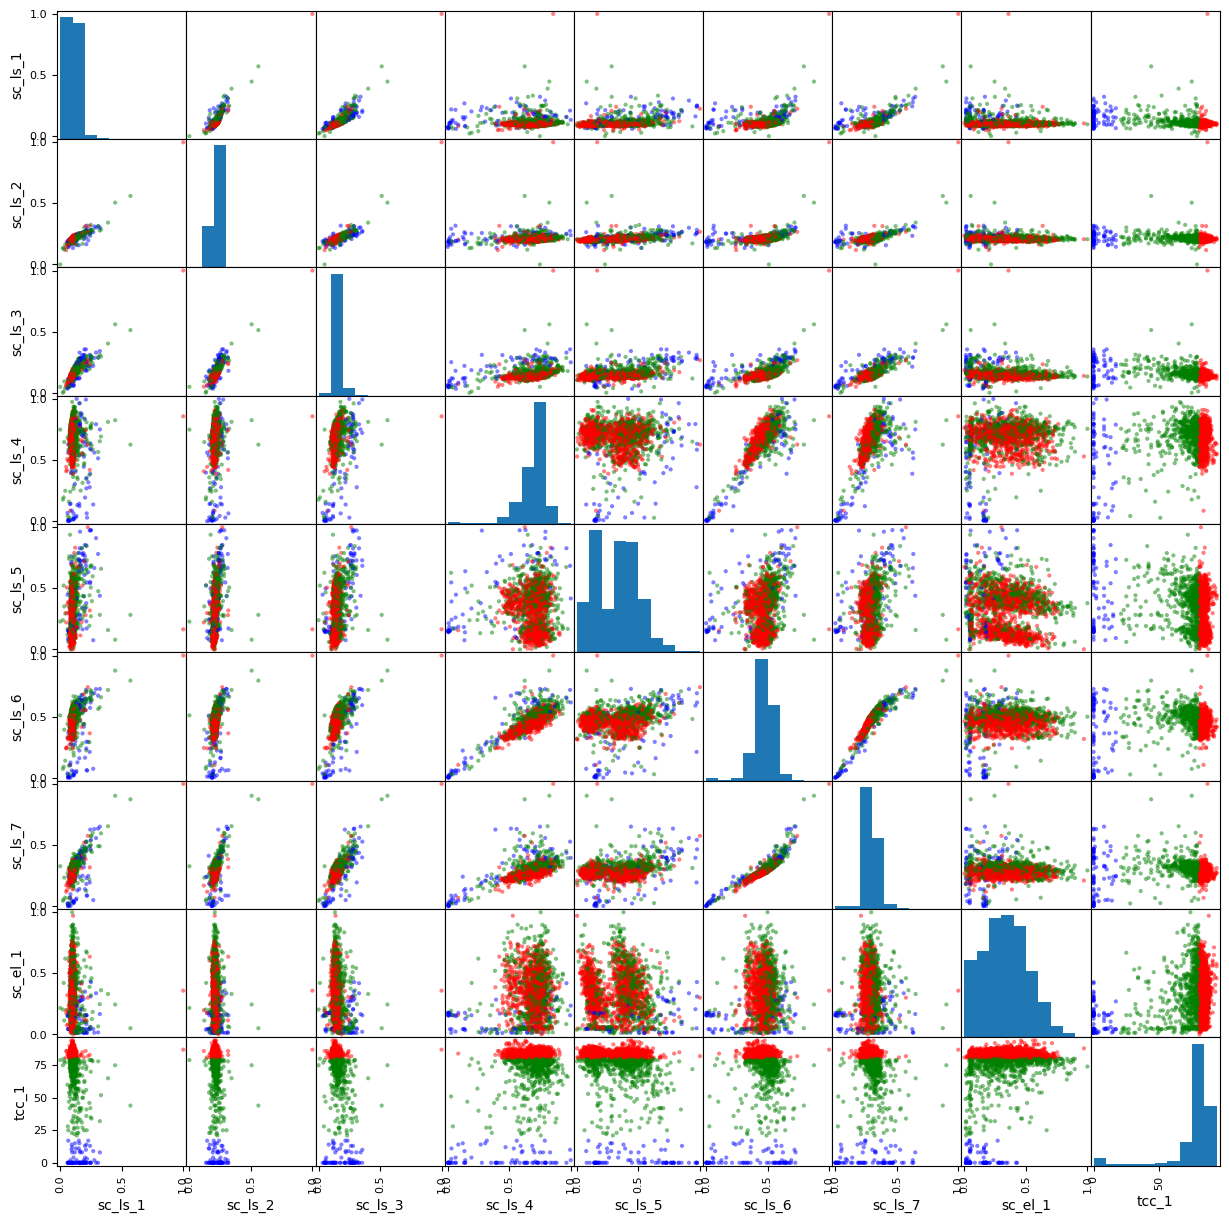

In [130]:
# create a scatter plot matrix of continuous predictors and tree canopy cover colored by tree density class
col={'low':'blue','medium':'green','high':'red'}
gdf_m3_sc=gdf_m3[['sc_ls_1','sc_ls_2','sc_ls_3','sc_ls_4','sc_ls_5','sc_ls_6','sc_ls_7','sc_el_1','tcc_1']]
display(gdf_m3_sc.describe())
pd.plotting.scatter_matrix(gdf_m3_sc,color=gdf_m3['forest_density'].replace(col),figsize=(15,15))

The scatter plot matrix graphically display a lot of information. If we look at the bottom row (tcc_1), we can visually see any underlying trends between TCC and each of the scaled landsat and elevation variables. Looking at the other rows of our matrix, let us see underlying relationships or trends among predictor variables. Finally, looking at the diagonal of the matrix reveals the underlying distribution of each variables. 

What are you first impressions of the data?
    - Do you see any trending between TCC and the predictor variables?
    - Do you see any clumping between Forest Density (the colors) and the predictor variables?
    - Are all the variables normally distributed?
    - Are there any trends among predictor variables?

For example, let's look specifically at the tcc_1 histogram. The distribution of tcc-1 appears to be skewed left. To make this data more normally distributed, we can square or cube our tcc_1 values.

<Axes: ylabel='Frequency'>

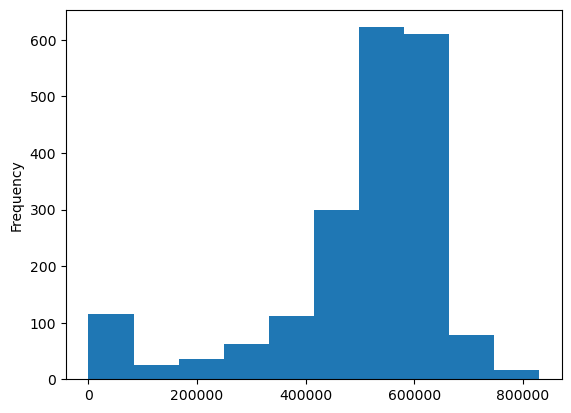

In [131]:
#cubing tcc_1

vls=gdf_m3_sc['tcc_1']**3
vls.plot(kind='hist')

#does this make tcc_1 more normal?
#What impact does this have with regard to the predictor variable?
#Could we make a new scatter plot with the transformed value?

Additionally, the scatter plot matrix can be used to identify trends in predictor variables in a multivariate way. Looking back at the scatter plot matrix we can see that there is significant linear trends in the predictor variables. This can be problematic for some modeling techniques. To address the colinear issue we can use a ordination technique like principal component analysis.  

pca0      pca1      pca2      pca3      pca4      pca5      pca6  \
0 -0.050937 -0.034956 -0.069683  0.085383 -0.560736 -0.039936 -0.063998   
1  0.052938  0.055566  0.085153  0.262640  0.730618  0.280892  0.193979   
2  0.032787  0.036327  0.105603  0.718794 -0.344392  0.456808  0.277933   
3  0.464957  0.281293  0.404410 -0.480056 -0.175956  0.209497  0.482719   
4 -0.332046 -0.345427 -0.505861 -0.370101 -0.035401  0.506823  0.345365   
5  0.151221  0.747192 -0.526281 -0.028489 -0.007835  0.251198 -0.278661   
6  0.244227  0.030978 -0.480092  0.194524  0.027709 -0.560726  0.596526   
7  0.764574 -0.486488 -0.223244  0.031381  0.011152  0.180439 -0.308610   

       pca7  
0  0.814814  
1  0.517251  
2 -0.255465  
3  0.053117  
4 -0.012451  
5 -0.015481  
6 -0.006406  
7 -0.003175

<Axes: >

% variance explained
 [0.37121663 0.33382759 0.23295837 0.04809716 0.01048658 0.00191685
 0.00095593 0.00054089]


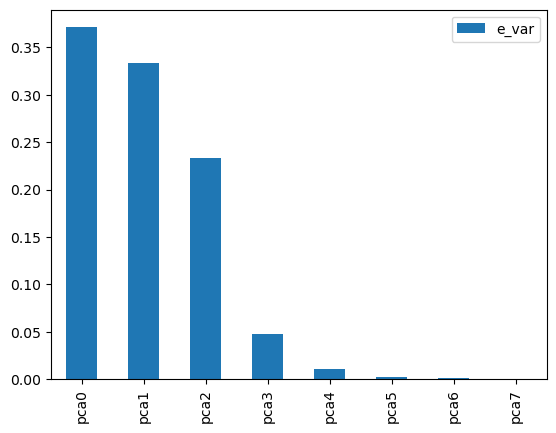

In [132]:
#import sklearn PCA decomposition module
from sklearn.decomposition import PCA


#create a PCA object
pca=PCA()

#fit the scaled Landsat data (sdf1)
pca.fit(sdf1)

#Look at the loading values components
display(pd.DataFrame(pca.components_,columns=pca.get_feature_names_out()))

#Look at the % variance explained by each component
display(pd.DataFrame(pca.explained_variance_ratio_,index=pca.get_feature_names_out(),columns=['e_var']).plot(kind='bar',use_index=True))
print('% variance explained\n',pca.explained_variance_ratio_)

array([[<Axes: xlabel='t_tcc', ylabel='t_tcc'>,
        <Axes: xlabel='pca0', ylabel='t_tcc'>,
        <Axes: xlabel='pca1', ylabel='t_tcc'>,
        <Axes: xlabel='pca2', ylabel='t_tcc'>,
        <Axes: xlabel='pca3', ylabel='t_tcc'>,
        <Axes: xlabel='pca4', ylabel='t_tcc'>,
        <Axes: xlabel='pca5', ylabel='t_tcc'>,
        <Axes: xlabel='pca6', ylabel='t_tcc'>,
        <Axes: xlabel='pca7', ylabel='t_tcc'>],
       [<Axes: xlabel='t_tcc', ylabel='pca0'>,
        <Axes: xlabel='pca0', ylabel='pca0'>,
        <Axes: xlabel='pca1', ylabel='pca0'>,
        <Axes: xlabel='pca2', ylabel='pca0'>,
        <Axes: xlabel='pca3', ylabel='pca0'>,
        <Axes: xlabel='pca4', ylabel='pca0'>,
        <Axes: xlabel='pca5', ylabel='pca0'>,
        <Axes: xlabel='pca6', ylabel='pca0'>,
        <Axes: xlabel='pca7', ylabel='pca0'>],
       [<Axes: xlabel='t_tcc', ylabel='pca1'>,
        <Axes: xlabel='pca0', ylabel='pca1'>,
        <Axes: xlabel='pca1', ylabel='pca1'>,
        <Axes: xlabe

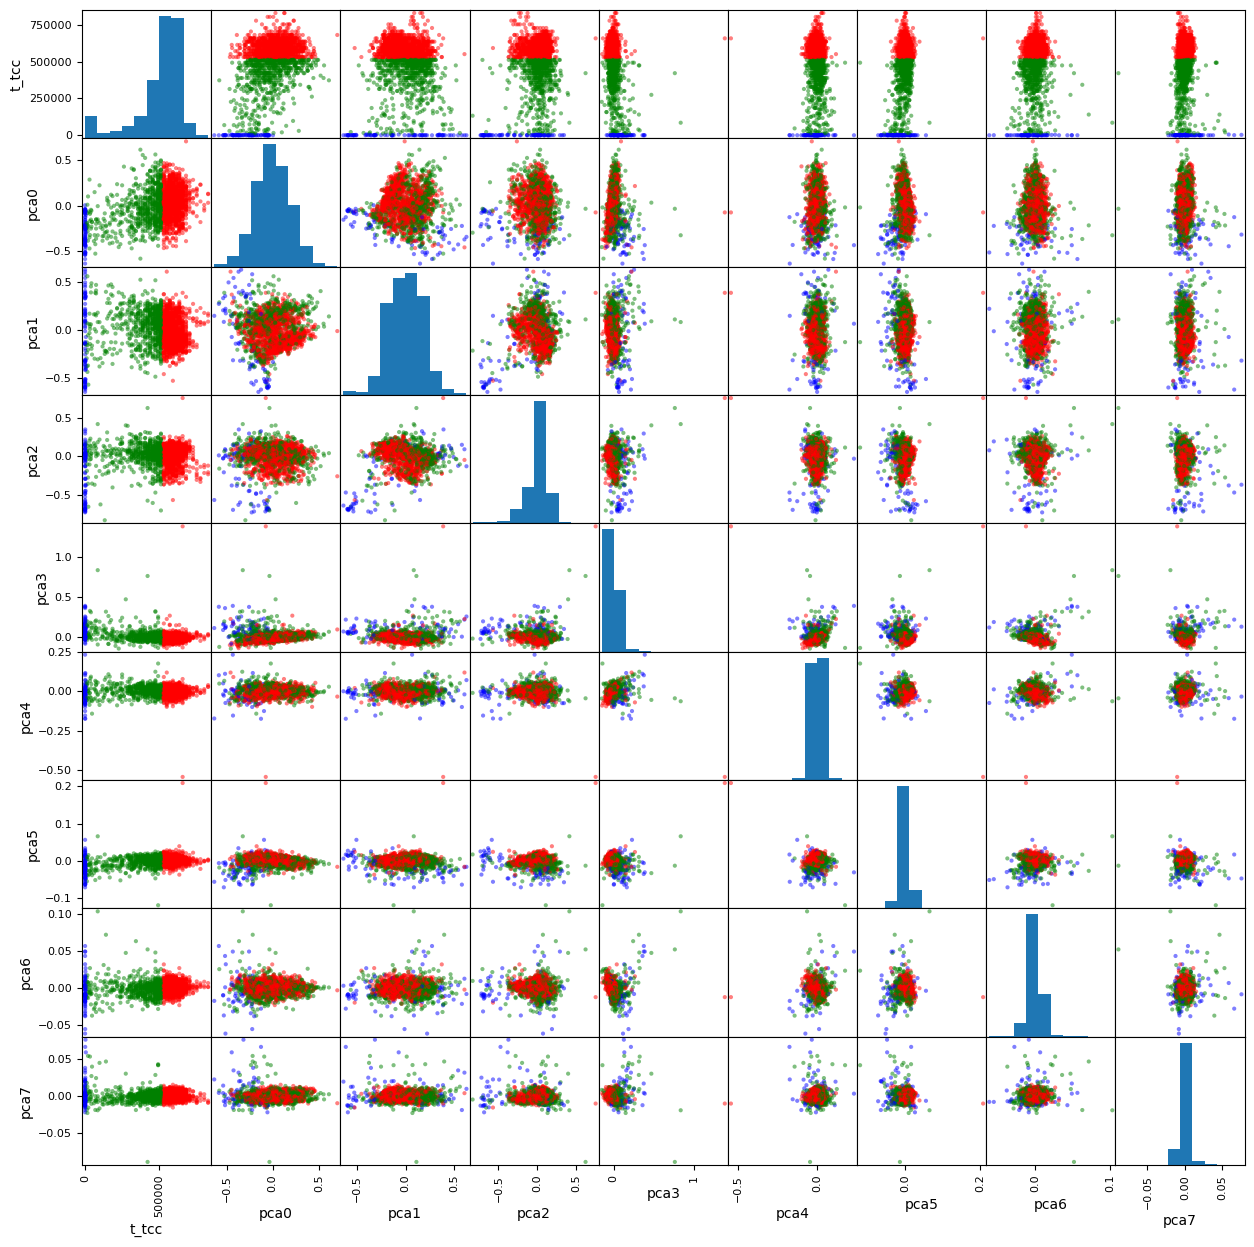

In [133]:
#Create a dataframe of transformed values
pca_df=pd.DataFrame(pca.transform(sdf1),columns=pca.get_feature_names_out())

#Add those values back to our gdf_m3 dataframe
gdf_m3=pd.concat([gdf_m3,pca_df],axis=1)

#Look at the new scatter plot of values including the transformed tcc variable
gdf_m3['t_tcc']=vls
pd.plotting.scatter_matrix(gdf_m3[['t_tcc','pca0','pca1','pca2','pca3','pca4','pca5','pca6','pca7']],color=gdf_m3['forest_density'].replace(col),figsize=(15,15))


#What pca columns should we keep?
#Should we standardize our Landsat values or scale them?
#What do the PCA loadings mean?
#what is another ordination technique we could use?


##### Step 3: Looking for patterns in the data
Often patterns are easier to see in data that have been transformed. We can see that there appears to be somewhat of a linear trend between t_tcc and pca0 and pca1. Let's look closer at this relationship by creating a scatter plot of t_tcc by pca0 and pca1.

PCA 0 by PCA 1 with t_tcc colored green as t_tcc increases


c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\geopandas\plotting.py:982: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  return PlotAccessor(data)(kind=kind, **kwargs)


<Axes: xlabel='pca0', ylabel='pca1'>

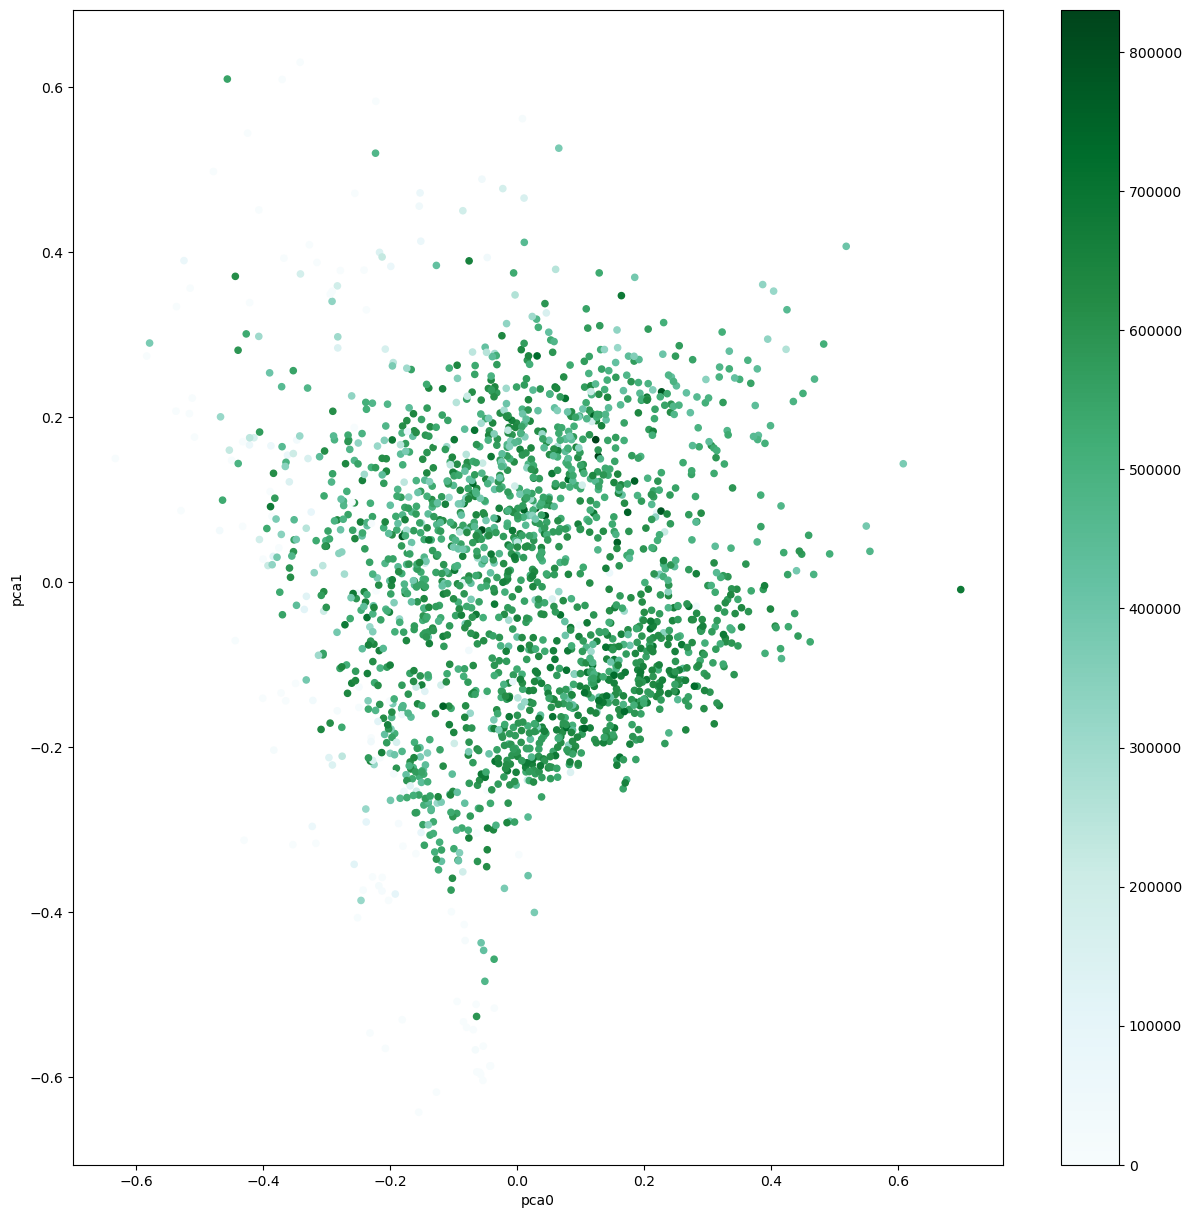

In [134]:
#scatter plot of pca0 by pca1 with t_tcc as a color
print('PCA 0 by PCA 1 with t_tcc colored green as t_tcc increases')
gdf_m3.plot(kind='scatter',x='pca0',y='pca1',cmap='BuGn',color=gdf_m3['t_tcc'],figsize=(15,15))

# What would this look like if we used forest density?
#gdf_m3.plot(kind='scatter',x='pca0',y='pca1',color=gdf_m3['forest_density'].replace(col),figsize=(15,15))
# Are low, medium, and high densities grouped?
# Why did we just plot PCA0 by PCA1?
# What proportion of the information does PCA0 and PCA1 account for in the data?
# What other techniques could we use to transform our data? 
# Which variables should we use in our model?

### Section 7: Building a predictive model
#### In this section we will explore how to build a model that can be used later to predict new estimates. While there are many different modeling techniques that can be used to group data or draw a relationship between response and predictor variables, we can generally split these techniques into three groups: 1) clustering, 2) regression, and 3) classification. 

- Clustering is used to group observations with similar values and can include continuous and categorical variables depending on the technique.
- Regression is used to estimate a continuous response value. Predictor variables can be either continuous or categorical.
- Classification is used to estimate a categorical response value. Predictors can be either continuous or categorical.

To demonstrate each instance, we will use the following techniques to group like observations, estimate transformed tcc, and classify tree density:
- K-means for clustering
- Random Forest for regression 
- Nnet regression for a classification

While there are many different modeling techniques one can use, it is very important to understand the underlying assumptions of a given model and when one modeling technique would be preferred to another technique. For a full description of each modeling technique please refer to the scientific literature. 

#### Key learning points:
- Training, testing, and validation
- Modeling and inference
- Saving a model

#### Coding steps
1. Training, testing, and validation
2. Model inference
3. Saving a model

##### Step 1: Training, testing, and validation
Many of the machine learning techniques do an excellent job at fitting the data exactly. However this situation can lead to a model that does very well reproducing the data but that does not generalize well to new data (over fitting). To evaluate how well a model is doing for new observations, data scientist often employ a technique that splits data into multiple groups and uses one group to train the model (training data), another group to evaluate the model (test data), and even a third group, separate from what was used to train or test the model, to evaluate the model. In this next exercise we will subset our gdf_m3 dataframe into response and predictor variables and further split our dataset into 3 groups that will be used to training (~33%), testing (~33%), and validation (~33%) our models.

In [135]:
#subset the data to the variables we will be using in the models
sub_gdf=gdf_m3[['forest_density','red_cat_1.0', 'red_cat_2.0', 'red_cat_3.0', 'pca0', 'pca1', 'pca2',
       'pca3', 'pca4', 'pca5', 'pca6','pca7', 't_tcc']].copy()

#get the total number of observation in the dataframe
n=sub_gdf.shape[0]

#create a random number for each observation in the dataframe
sub_gdf.loc[:,'rnd']=np.random.random(n)

#sort the dataframe by the random numbers
sub_gdf=sub_gdf.sort_values('rnd')

#split the data into 3 groups based on their sorted row count
sp=int(n*0.33)
train=sub_gdf.iloc[:sp]
test=sub_gdf.iloc[sp:sp*2]
val=sub_gdf.iloc[sp*2:]

#look at the training data
train

#How many observations are in the train, test, and val?
#Can you think of a different way to randomly select observations from your dataframe?
#Should the distribution of each dataframe be the same?
#Are the distribution of each dataframe the same?

forest_density  red_cat_1.0  red_cat_2.0  red_cat_3.0      pca0  \
689            high          0.0          0.0          1.0  0.143664   
1015           high          0.0          0.0          1.0 -0.232050   
683            high          0.0          0.0          1.0  0.043477   
1017           high          0.0          0.0          1.0 -0.105017   
849            high          0.0          0.0          1.0 -0.150304   
...             ...          ...          ...          ...       ...   
828          medium          0.0          1.0          0.0  0.033656   
1966           high          0.0          0.0          1.0  0.015502   
1436           high          0.0          0.0          1.0  0.125405   
64             high          0.0          0.0          1.0 -0.092853   
703          medium          0.0          1.0          0.0  0.087806   

          pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
689  -0.146660  0.123556 -0.023066  0.000398 -0.000113  0.009301  0.001791   
1015  0.023668 -0.097248 -0.063068 -0.030140 -0.002415  0.003484 -0.001065   
683  -0.181097  0.117530  0.017619  0.052843  0.011481 -0.002437  0.003848   
1017  0.145276 -0.096308  0.017311  0.037985  0.000745  0.006535 -0.000658   
849   0.196771  0.007553  0.003048  0.015103  0.011556 -0.006581 -0.001670   
...        ...       ...       ...       ...       ...       ...       ...   
828   0.308526 -0.023076 -0.000547  0.008636  0.018693 -0.006473  0.008125   
1966 -0.044151  0.034219 -0.082337 -0.052270  0.004034  0.013881 -0.001010   
1436  0.093750 -0.092035 -0.014018  0.001451  0.006467 -0.001660 -0.000058   
64   -0.337476  0.136964  0.032981 -0.005422 -0.004128 -0.011223 -0.005144   
703  -0.149297  0.113313 -0.039600 -0.020606  0.008274  0.006840  0.009873   

         t_tcc       rnd  
689   551368.0  0.000196  
1015  551368.0  0.000517  
683   658503.0  0.000566  
1017  531441.0  0.000841  
849   551368.0  0.001948  
...        ...       ...  
828   512000.0  0.313491  
1966  592704.0  0.314651  
1436  531441.0  0.314961  
64    592704.0  0.316982  
703   421875.0  0.317150  

[653 rows x 14 columns]

##### Step 2: Modelling and inference
Now that we have 3 datasets we can begin building models and interpreting the results. In the next few cells we will do the following:
- build a k-means clustering model, test our estimates, validate our model, and interpret our results
- build a Random Forest regression model, test our estimates, validate our model, and interpret our results
- build a Multinomial logistic regression model for classification test our estimates, validate our model, and interpret our results


K-means cluster example using PCA variables. Clustering is typically used to group like observations. To evaluate our clusters in this case we will compare the distribution of our cluster labels for our training, testing, and validation datasets. 

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\jshogland\AppData\Local\Temp\ipykernel_15176\3105919690.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lbl']=km.predict(X_train)
C:\Users\jshogland\AppData\Local\Temp\ipykernel_15176\3105919690.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

pca0       Axes(0.125,0.11;0.0824468x0.77)
pca1    Axes(0.223936,0.11;0.0824468x0.77)
pca2    Axes(0.322872,0.11;0.0824468x0.77)
pca3    Axes(0.421809,0.11;0.0824468x0.77)
pca4    Axes(0.520745,0.11;0.0824468x0.77)
pca5    Axes(0.619681,0.11;0.0824468x0.77)
pca6    Axes(0.718617,0.11;0.0824468x0.77)
pca7    Axes(0.817553,0.11;0.0824468x0.77)
dtype: object

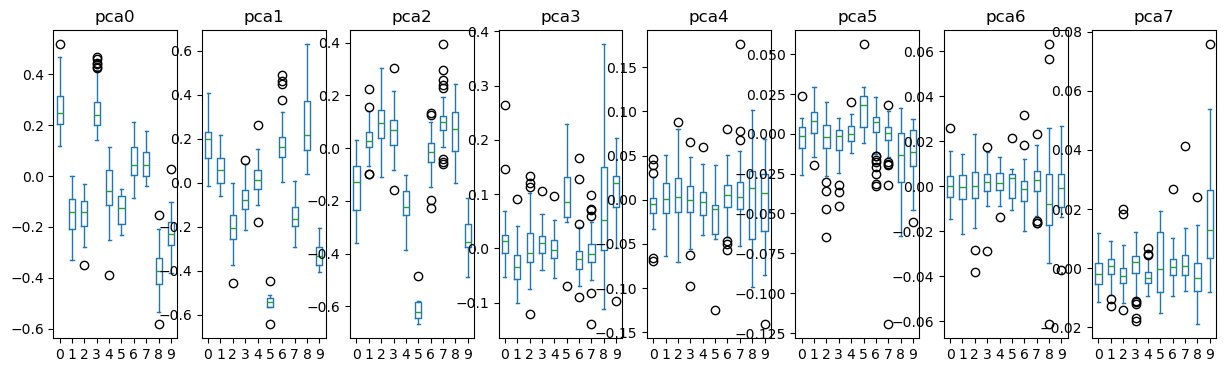

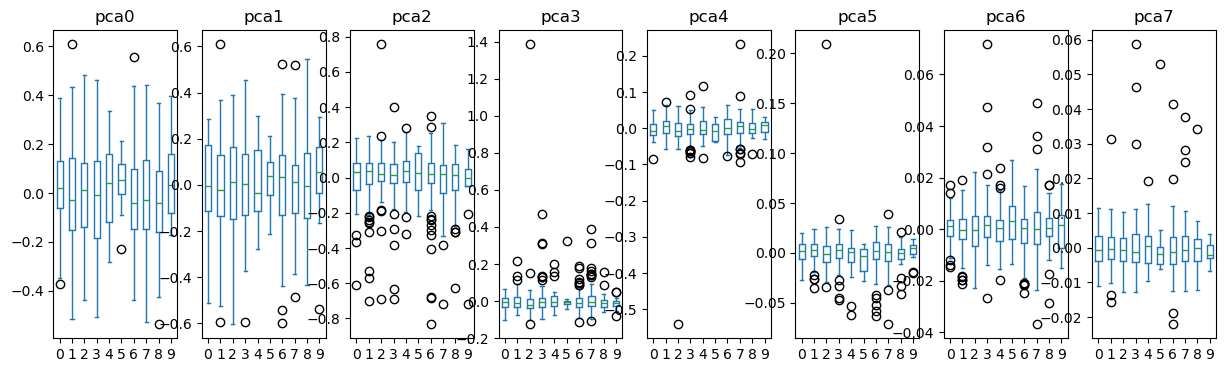

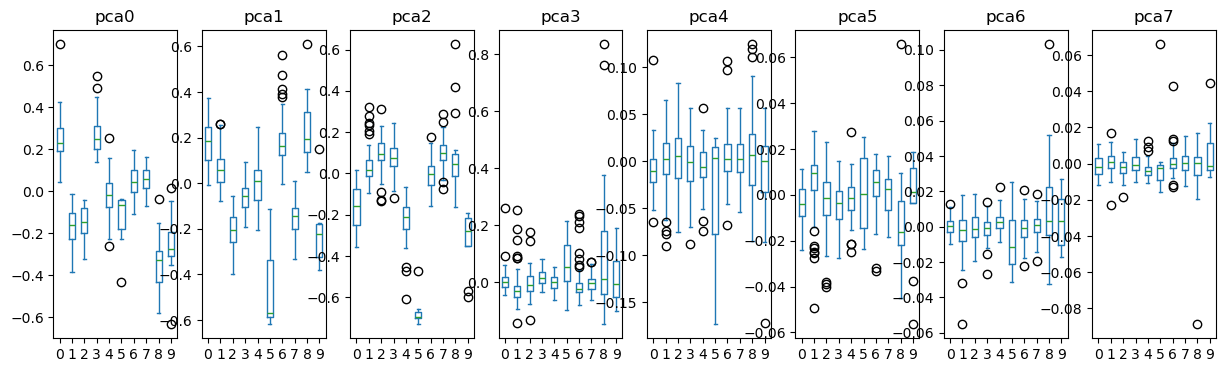

In [136]:
from sklearn.cluster import KMeans
# create the X data frame of predictors (only continuous variable are applicable for kmeans)
pred_clm=['pca0', 'pca1', 'pca2',
       'pca3', 'pca4', 'pca5', 'pca6','pca7']
X_train=train[pred_clm]

X_test=train[pred_clm]

X_val=val[pred_clm]

# create the KMeans object with 10 clusters
km=KMeans(10)

#fit the model using the training data
km.fit(X_train)

#apply the model to train, test, and validation datasets
train['lbl']=km.predict(X_train)
test['lbl']=km.predict(X_test)
val['lbl']=km.predict(X_val)

#look at the box plot of each lbl and principal component value
train[pred_clm+['lbl']].plot(kind='box',by='lbl',figsize=(15,4))
test[pred_clm+['lbl']].plot(kind='box',by='lbl',figsize=(15,4))
val[pred_clm+['lbl']].plot(kind='box',by='lbl',figsize=(15,4))

#Do the distribution look different for each dataset?
#What are the means and standard deviation for each label within each dataset?
#Can we test to see if the distributions are different?

#How can we see if each class label is roughly the same size?
# display(np.unique(train['lbl'],return_counts=True))
# display(np.unique(test['lbl'],return_counts=True))
# display(np.unique(val['lbl'],return_counts=True))


#Which label has the smallest number of observations?
#What would happen if you selected 5 clusters?
#Did we really need a train, test, and validation dataset?

#Create a scatter plot of pca0 by pca1 with observations colored based on the k-mean label
# train.plot(kind='scatter',x='pca0',y='pca1',color=train['lbl'],cmap='Paired',figsize=(15,15))

#why would we cluster objects?
#What other clustering techniques are available?
#How could we use our categorical values?
#Is there a relationship between our clusters and forest_density?
#Is there a relationship between our clusters and TCC?

Estimating Tree Canopy Cover (TCC) using Random Forest Regression and PCA and red_cat predictor variables. Random Forest Regression is an ensemble of CART models which can be used to estimate continuous variables (it can also be used for classification purposes). It can use both continuous and categorical predictor variables as inputs. To evaluate or model, we will apply it on test and validation datasets and compare the observed TCC values against the Predicted TCC values.

OOB r-squared = 0.798489736134401
test r-squared = 0.7894902793348967
test RMSE = 77035.12929749208
val r-squared = 0.770997273051559
val RMSE = 77305.53558126563


C:\Users\jshogland\AppData\Local\Temp\ipykernel_15176\3071890861.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'pred_tcc']=rndf.predict(Xts)
C:\Users\jshogland\AppData\Local\Temp\ipykernel_15176\3071890861.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val.loc[:,'pred_tcc']=rndf.predict(Xvl)


<Axes: title={'center': 'Val obs vs pred'}, xlabel='pred_tcc', ylabel='t_tcc'>

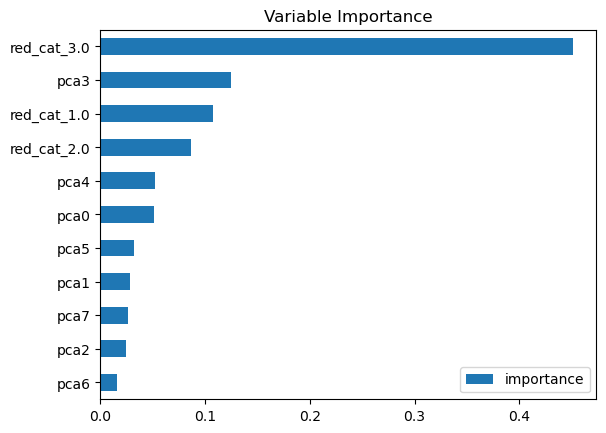

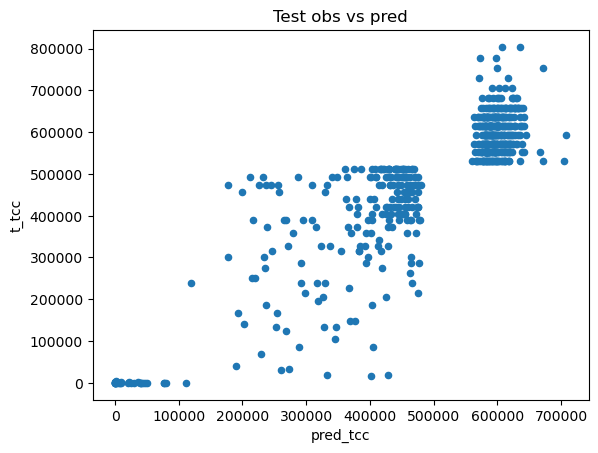

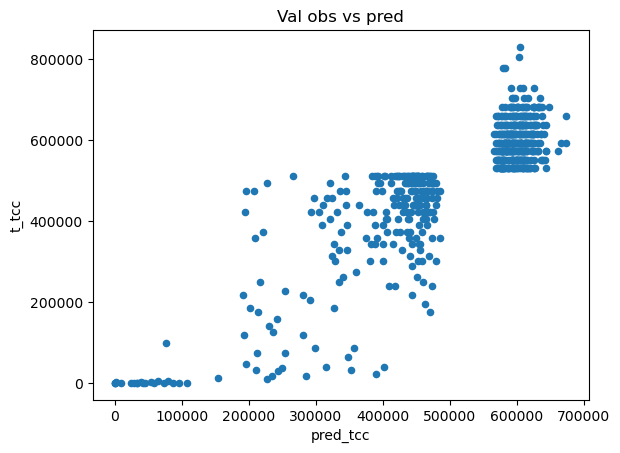

In [137]:
from sklearn.ensemble import RandomForestRegressor

#Create our predictor and response arrays
pred=['red_cat_1.0', 'red_cat_2.0', 'red_cat_3.0', 'pca0',
       'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6','pca7']
resp='t_tcc'


Xtr=train[pred]
ytr=train[resp]

#get our test and validation array
Xts=test[pred]
Xvl=val[pred]

#create the Random forest regressor 
rndf = RandomForestRegressor(oob_score=True,max_samples=0.8, random_state=0)

#fit the model
rndf.fit(Xtr, ytr)

#Fit stats
print('OOB r-squared =',rndf.oob_score_)# out of bag r squared (% of variance explained)

#plot variable importance
pd.DataFrame(rndf.feature_importances_,index=pred,columns=['importance']).sort_values(by='importance').plot(kind='barh', title='Variable Importance')

#predict our values for test and validation
test.loc[:,'pred_tcc']=rndf.predict(Xts)
val.loc[:,'pred_tcc']=rndf.predict(Xvl)

#display r-squared and plot observed vs predicted for test
print('test r-squared =',test[['t_tcc','pred_tcc']].corr().iloc[0,1]**2)
print('test RMSE =', np.sqrt(((test['t_tcc']-test['pred_tcc'])**2).mean()))
test.plot(kind='scatter',y='t_tcc',x='pred_tcc',title='Test obs vs pred')

#display r-squared and plot observed vs predicted for test
print('val r-squared =',val[['t_tcc','pred_tcc']].corr().iloc[0,1]**2)
print('val RMSE =', np.sqrt(((val['t_tcc']-val['pred_tcc'])**2).mean()))
val.plot(kind='scatter',y='t_tcc',x='pred_tcc',title='Val obs vs pred')

#which variables are most important?
#How is importance being calculated?
#What units are t_tcc?
#if we want to look at TCC what do we need to do?
# print('TCC r-squred =',(val[['t_tcc','pred_tcc']]**(1/3)).corr().iloc[0,1]**2)
# (val[['t_tcc','pred_tcc']]**(1/3)).plot(kind='scatter',y='t_tcc',x='pred_tcc')
#Does our obb give a reliable estimate of r-squared?

Classifying forest_density using a neural network (Nnet) and PCA and red_cat predictor variables. Like Random Forest, Nnets can be used for regression and classification. Additionally, Nnets can use both continuous and categorical predictor variables as inputs. To evaluate or model, we will apply it on test and validation datasets and compare the observed forest_density classes against the predicted classes values.

In [138]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import contingency_matrix


nnet_cl=MLPClassifier(random_state=0,activation='logistic',max_iter=300)

pred=['red_cat_1.0', 'red_cat_2.0', 'red_cat_3.0', 'pca0',
       'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6','pca7']
resp='forest_density'

#get our train data array
Xtr=train[pred]
ytr=train[resp]

#get our test and validation array
Xts=test[pred]
Xvl=val[pred]

#fit the model
nnet_cl.fit(Xtr,ytr)


#Fit stats
print('Nnet overall accuracy (training) =',accuracy_score(y_true=ytr, y_pred=nnet_cl.predict(Xtr)))# % accuracy
print('Nnet overall accuracy(test) =',accuracy_score(y_true=test[resp], y_pred=nnet_cl.predict(Xts)))# % accuracy
print('Nnet overall accuracy(validation) =',accuracy_score(y_true=val[resp], y_pred=nnet_cl.predict(Xvl)))# % accuracy
print('\nNnet Contingency_matrix (validation):\n',contingency_matrix(labels_true=val[resp],labels_pred=nnet_cl.predict(Xvl)))

#Calculate the class probabilities for train, test and val
tr_prob=pd.DataFrame(nnet_cl.predict_proba(Xtr),columns=nnet_cl.classes_)
ts_prob=pd.DataFrame(nnet_cl.predict_proba(Xts),columns=nnet_cl.classes_)
vl_prob=pd.DataFrame(nnet_cl.predict_proba(Xvl),columns=nnet_cl.classes_)

#What does the overall accuracy and the contingency matrix for train, test and val tell us?
#What do these probabilities tell us?

Nnet overall accuracy (training) = 1.0
Nnet overall accuracy(test) = 1.0
Nnet overall accuracy(validation) = 1.0

Nnet Contingency_matrix (validation):
 [[416   0   0]
 [  0  20   0]
 [  0   0 237]]


<Axes: xlabel='pca0'>

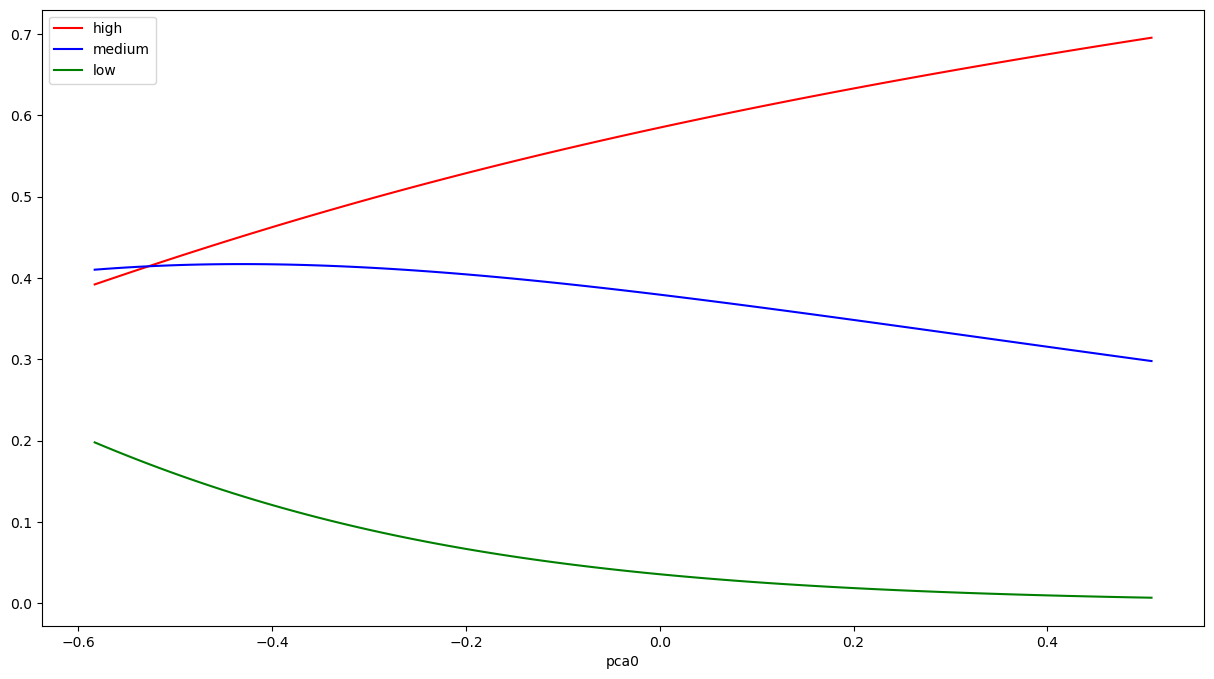

In [139]:
#Create a scatter plot of probabilities vs pca0 holding other predictors at the 25th quantiles
dsc=Xtr.describe()
dsc_mean=dsc.loc['25%'].drop(index=['pca0'])
dsc_min=dsc.loc['min']
dsc_max=dsc.loc['max']
stp=(dsc_max.loc['pca0']-dsc_min.loc['pca0'])/100
pca0=np.arange(dsc_min.loc['pca0'],dsc_max.loc['pca0'],stp)
df_graph=pd.DataFrame(pca0,columns=['pca0'])
df_graph.loc[:,dsc_mean.index.values]=dsc_mean.values
df_graph[nnet_cl.classes_]=nnet_cl.predict_proba(df_graph[Xtr.columns])
p=df_graph.plot(x='pca0',y='high',color='red',figsize=(15,8))
p=df_graph.plot(ax=p,x='pca0',y='medium',color='blue')
p=df_graph.plot(ax=p,x='pca0',y='low',color='green')
p

#What does this graphic tell us?
#how would you calculate probability error?

##### Step 3: Saving the model
Often we will want to store a given model to use at a later time. We can easily serialize and load a model using the pickle package.

In [140]:
import pickle

#let's store our kmeans, random forest, and nnet models
pickle.dump(km,open('km.mdl','wb'))#kmeans
pickle.dump(rndf ,open('rndf.mdl','wb'))#random forest regression
pickle.dump(nnet_cl,open('nnet_cl.mdl','wb'))#neural network classification

#to load our model back into ram we can call the load method for each saved model
km = pickle.load(open('km.mdl', 'rb'))
rndf = pickle.load(open('rndf.mdl', 'rb'))
nnet_cl = pickle.load(open('nnet_cl.mdl', 'rb'))

#let's look at the oob r-squared value from our loaded random forest regression model
rndf.oob_score_

#How can you use your stored model?
#Why would you want to store a model?

0.798489736134401

### Section 8: Estimating % Tree Canopy Cover
#### In this section we will explore how to use a model to create new estimates using Raster Tools and our 2016 Landsat scene.

#### Key learning points:
- What are we estimating?
- Estimation domain
- Estimates of error

#### Coding steps
1. Transforming raster surfaces to standardized values
2. Applying a model to raster surfaces
3. Interpolating results (no extrapolation)
4. Estimating error at the cell level
5. Estimating error at a coarser scale

##### Step 1: Transforming Raster surfaces to standardized PCA and encoded values
In order to build our models we need to go back through the steps used to scale and transform our data. Fortunately, we still have our MinMax scaler, and PCA models which we can use to create a function that can convert landsat cell values into values our model is expecting. Likewise, we can use the functionality within Raster Tools to duplicate our OneHoteEconding model. In total, we have 11 predictor variables (8 principal components and 3 OneHotEncoded variables). This means that we need to create a 11 band raster surface with values that each of our models are expecting (band order being the same as what was used to create the model).
- km model - pca0-pca7
- rndf model = pca0-pca7 and red_cat1.0-3.0 with value of 1 or 0
- nnet_cl model = pca0-pca7 and red_cat1.0-3.0 with values of 1 or 0

Let's start with creating our PCA surfaces, then create our encoded surfaces, and finally combine our surfaces for each modeling technique.


In [182]:
from sklearn.pipeline import Pipeline

#Let's use a pipeline to combine the scaling and PCA steps
pipe = Pipeline(steps=[("scaler", mms), ("pca", pca)])

#first we need to snap our raster datasets to the same cell location
dem2=dem.reproject(ls82016.geobox)

#Let's stack our landsat and dem raster surfaces
ors=general.band_concat([ls82016,dem2])

#Let's use Raster Tools ModelPredictAdaptor to create a model that has predict function that Raster Tools can use
pred_tr=general.ModelPredictAdaptor(pipe,'transform')

#Apply that model to our stacked raster to create input data for our kmeans model
pred_pca_rs=ors.model_predict(pred_tr,len(pca.get_feature_names_out()))

#Let's use logical functions to create our red_cat variables from landsat band 1
ls1_rs=ls82016.get_bands(1)
d_rs=(ls1_rs<0.022).astype('int')
b_rs=(ls1_rs>0.024).astype('int')
n_rs=((0.020<=ls1_rs) & (ls1_rs<=0.024)).astype('int')

#Let's combine our raster surfaces to create a 11 band raster we can use with our random forest and nnet models. 
#Make sure the order of the surfaces matches the order used to create the model
pred_rs=general.band_concat([d_rs,n_rs,b_rs,pred_pca_rs])


Now that we have our predictor surfaces, we can apply our km, rndf, and nnet_cl models. Let's start with our clustering model

In [192]:
#let's perform our kmeans clustering algorithm and visualize the results
import folium

#create a folium map
m=folium.Map()

#create our raster surface of our km classes
km_rs=pred_pca_rs.model_predict(km,1) #what does the one mean?

#add the NAIP imagery as a backdrop
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(m)

#add our kmeans raster to the map
m=km_rs.explore(map=m,band=1,cmap='tab10', name='kmean classes')

#display the map
m


##### Step 2: Applying a model to raster surfaces

##### Step 3: Interpolating results

##### Step 4: Estimating error at the cell level

##### Step 5: Estimating error at a courser scale 



One import issue that is often overlooked when modeling is determining when a model is interpolating vs extrapolating. So what does this mean? First, let's define these two cases. Interpolating means that predictions are made for new observations in which the predictor values fall within the range of values used to train the model. While, extrapolation occurs when the predictor values used to estimate the new observation fall outside of the range used to calibrate the model. In all cases interpolated estimates are preferred to extrapolated estimate. So what does this mean with regards to the number of variables used to train a model and the models ability to be generalized to the population? Generally, this means that as you increase the number of variables used in a model, you also need to increase the number of observation used to train the model to insure capturing the range of all potential predictor variable values(domain). This situation is often referred to as the curse of dimensionality. Can you think of other issues associated with increasing the number of predictor variables used in a model? 

When designing a sample or training set, special effort should be made to insure your sample is well spread and balanced to the naturally occurring distribution of the population. Additionally, once a model has been built it is always a good idea to define the range in which estimates are being interpolated vs extrapolating. To do this let's assume we will be using all 7 bands from our Landsat Image as our predictor variables. Using our sample of 1983 observations from dataframe (gdf_m3) we can select build a simple model that queries all cells within our Landsat Image that fall within the range of sampled values using the values returned from describing our data as follows.   

### Section 9: Making a dashboard
#### In this section we will explore how to convert your results into a functioning dashboard

#### Key learning points:
- Displaying results
- Guiding the user
- Hosting